In [1]:
from argparse import ArgumentParser
import utils
import torch
from models.basic_model import CDEvaluator
import os
import numpy as np
import pandas as pd
from typing import TypedDict
import xarray as xr
import rioxarray as rxr
import boto3
import rasterio as rio
from rasterio.session import AWSSession
import os
import certifi
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(threads_per_worker=4)
client = Client(cluster)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


2022-05-17 19:19:37,616 - distributed.diskutils - INFO - Found stale lock file and directory '/home/dylan/code/planet-regrid-poc/SiameseCD/dask-worker-space/worker-kehevg7m', purging
2022-05-17 19:19:37,617 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [2]:
def get_args():
    # ------------
    # args
    # ------------
    parser = ArgumentParser()
    parser.add_argument('--project_name', default='BIT_LEVIR', type=str)
    parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
    parser.add_argument('--checkpoint_root', default='checkpoints', type=str)
    parser.add_argument('--output_folder', default='samples/predict', type=str)

    # data
    parser.add_argument('--num_workers', default=0, type=int)
    parser.add_argument('--dataset', default='CDDataset', type=str)
    parser.add_argument('--data_name', default='quick_start', type=str)

    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--split', default="demo", type=str)
    parser.add_argument('--img_size', default=256, type=int)

    # model
    parser.add_argument('--n_class', default=2, type=int)
    parser.add_argument('--net_G', default='base_transformer_pos_s4_dd8_dedim8', type=str,
                        help='base_resnet18 | base_transformer_pos_s4_dd8 | base_transformer_pos_s4_dd8_dedim8|')
    parser.add_argument('--checkpoint_name', default='best_ckpt.pt', type=str)

    args = parser.parse_args(args=[])
    return args

In [3]:
args = get_args()
utils.get_device(args)

In [104]:
def load_model():
    device = torch.device("cuda:%s" % args.gpu_ids[0]
                          if torch.cuda.is_available() and len(args.gpu_ids)>0
                        else "cpu")
    args.checkpoint_dir = os.path.join(args.checkpoint_root, args.project_name)
    os.makedirs(args.output_folder, exist_ok=True)

    log_path = os.path.join(args.output_folder, 'log_vis.txt')

    data_loader = utils.get_loader(args.data_name, img_size=args.img_size,
                                   batch_size=args.batch_size,
                                   split=args.split, is_train=False)

    model = CDEvaluator(args)
    model.load_checkpoint(args.checkpoint_name) 
    model.eval()
    return model

In [105]:
remote_model = client.submit(load_model)
print(remote_model)

<Future: finished, type: models.basic_model.CDEvaluator, key: load_model-47fcc82616a246de5215414aab858e4a>


# Load Planet Data

In [ ]:
os.environ.setdefault("CURL_CA_BUNDLE",certifi.where())

In [10]:
session = boto3.Session()

In [ ]:
session = boto3.Session(aws_access_key_id=os.getenv('makepath_pb_id'),
                       aws_secret_access_key=os.getenv('makepath_pb_key'))#,region_name="us-east-2"

In [ ]:
# os.environ['GS_SECRET_ACCESS_KEY']=os.getenv('makepath_pb_key')
# os.environ['GS_ACCESS_KEY_ID']=os.getenv('makepath_pb_id')
# os.environ['AWS_S3_ENDPOINT']='amplify.us-east-2.amazonaws.com'

In [11]:
rio_env = rio.Env(session=AWSSession(session))#,AWS_S3_ENDPOINT='amplify.us-east-2.amazonaws.com'
rio_env.__enter__()

In [ ]:
def get_file_names(bucket_name,prefix):
    """
    Return the latest file name in an S3 bucket folder.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (folder  name).
    """
    s3_client = boto3.client('s3',aws_access_key_id=os.getenv('makepath_pb_id'),
                       aws_secret_access_key=os.getenv('makepath_pb_key'))
    objs = s3_client.list_objects_v2(Bucket=bucket_name)['Contents']
    shortlisted_files = []    #dict({})      
    for obj in objs:
        key = obj['Key']
        timestamp = obj['LastModified']
        # if key starts with folder name retrieve that key
        if key.startswith(prefix) and key.endswith('.tif'):              
            # Adding a new key value pair
            shortlisted_files.append("s3://"+bucket_name+"/"+key)   #{key : timestamp}
    return shortlisted_files

In [ ]:
latest_filenames = get_file_names(bucket_name='makepath-planet-data',prefix = 'Full/')

In [106]:
file1 = '../data/test_small/20190129_164426_1018_3B_Visual.tif'
ds1 = rxr.open_rasterio(file1,lock=False)
ds1 = ds1[:3]
file2 = '../data/test_small/20200201_163705_0e19_3B_Visual.tif'
ds2 = rxr.open_rasterio(file2,lock=False)
ds2 = ds2[:3]

In [107]:
ds = xr.combine_nested([ds1,ds2],concat_dim="time").chunk((2,3,256,256))

In [108]:
ds

,Array,Chunk
Bytes,2.78 GiB,3.00 MiB
Shape,"(2, 3, 5659, 11008)","(2, 3, 256, 256)"
Count,989 Tasks,989 Chunks
Type,float64,numpy.ndarray


In [109]:
slices = {}
for coord in ["y","x"]:
    remainder = len(ds.coords[coord])%32
    slice_ = slice(-remainder) if remainder else slice(None)
    slices[coord] = slice_

In [110]:
ds_comb = ds.isel(**slices)

In [111]:
ds_comb

,Array,Chunk
Bytes,2.77 GiB,3.00 MiB
Shape,"(2, 3, 5632, 11008)","(2, 3, 256, 256)"
Count,1935 Tasks,946 Chunks
Type,float64,numpy.ndarray


In [112]:
import dask.array
def predict_chips(data,model)->torch.Tensor:
    result = model._forward_pass(data).cpu().numpy()[0][0]
    return result

def copy_and_predict_chunked(tile,model,token=None):
    slices = dask.array.core.slices_from_chunks(dask.array.empty(tile.shape).chunks)
    out = np.empty(shape=tile.shape[2:], dtype="uint8")
    device = torch.device("cuda")
    A = torch.as_tensor(tile[0][np.newaxis, ...]) #gpu_chip = torch.as_tensor(tile[slice_][np.newaxis, ...]).to(device)
    B = torch.as_tensor(tile[1][np.newaxis, ...])
    gpu_chip = {'name':'test','A':A.float().to(device),'B':B.float().to(device),'L':torch.zeros(1,1,256,256).float().to(device)}
    out = predict_chips(gpu_chip, model)
    return out

In [113]:
meta = np.array([[]], dtype="uint8")[:0]

predictions_array = ds_comb.data.map_blocks(
    copy_and_predict_chunked,
    meta=meta,
    drop_axis=[0,1],
    model=remote_model,
    name="predict",
)

predictions_array

predictions = xr.DataArray(
    predictions_array,
    coords=ds_comb.drop_vars("band").coords,
    dims=("y", "x"),
)
predictions

<xarray.DataArray 'predict-3b84cd32900419f5700f2dcbd18f3440' (y: 5632, x: 11008)>
dask.array<predict, shape=(5632, 11008), dtype=uint8, chunksize=(256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6.21e+05 6.21e+05 6.21e+05 ... 6.541e+05 6.541e+05
  * y            (y) float64 3.349e+06 3.349e+06 ... 3.366e+06 3.366e+06
    spatial_ref  int64 0

In [114]:
test = predictions.compute()

In [117]:
test_small = test[1500:2500,1500:2500]
ds1_small = ds1[:,1500:2500,1500:2500]
ds2_small = ds2[:,1500:2500,1500:2500]

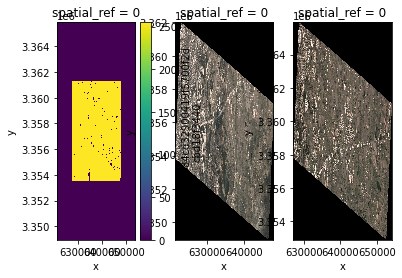

In [136]:
import matplotlib.pyplot as plt
from rasterio.plot import show
fig,axs = plt.subplots(1,3)
test.plot.imshow(ax=axs[0])
ds1.plot.imshow(ax=axs[1])
ds2.plot.imshow(ax=axs[2])